# `DataSet`: `Targets` observed by a `Survey`

learn how to merge target inside a survey and simulate a dataset (observed version of target's data)

In [1]:
import skysurvey

***
## Build Targets

Following what we learned in Quickstart: target, let's create a SNeIa dataset:
- 1 000 targets 
- observed between $\mathrm{ra}\in[100, 200]$ deg and $\mathrm{dec}\in[-20, 30]$
- with $z<0.3$
- between mjd=56_000 and 56_200

### Target | data given by nature

In [31]:
%%time
snia = skysurvey.SNeIa.from_draw(1_000, 
                                 zmax=0.3,
                                 tstart=56_000, tstop=56_200,
                                 radec={"ra_range":[100, 200], "dec_range":[-20,30]}, )

CPU times: user 25.6 ms, sys: 4.34 ms, total: 30 ms
Wall time: 29 ms


**tip**: `from_draw()` (like `draw()`) accepts that you change any model kwargs with way: *param_name = kwargs*. Here *param_name* is `radec` and the new *kwargs* are `{"ra_range":[100, 200], "dec_range":[-20,30]}` ; See self.model:

In [32]:
snia.model

{'redshift': {'kwargs': {'zmax': 0.2}, 'as': 'z'},
 'x1': {'func': <function SNeIaStretch.nicolas2021 at 0x285137d30>},
 'c': {'func': <function SNeIaColor.intrinsic_and_dust at 0x2833c5e50>},
 't0': {'func': <built-in method uniform of numpy.random.mtrand.RandomState object at 0x106597640>,
        'kwargs': {'low': 56000, 'high': 57000}},
 'magabs': {'func': <function SNeIaMagnitude.tripp1998 at 0x285137dc0>,
            'kwargs': {'x1': '@x1', 'c': '@c', 'mabs': -19.3, 'sigmaint': 0.1}},
 'magobs': {'func': 'magabs_to_magobs',
            'kwargs': {'z': '@z', 'magabs': '@magabs'}},
 'x0': {'func': 'magobs_to_amplitude',
        'kwargs': {'magobs': '@magobs', 'param_name': 'x0'}},
 'radec': {'func': <function random_radec at 0x2833bf280>,
           'kwargs': {},
           'as': ['ra', 'dec']}}

***
## Survey 

Let's define a random survey:
- **Observing strategy**:
    - 50_000 poitings
    - starts 10days after the first SNeIa stops 20days after the last
    - covers $\mathrm{ra}\in[100, 200]$ deg and $\mathrm{dec}\in[-20, 30]$ 
    - has a skynoise $\mathcal{N}(350,20)$
    - has a gain of 2
    - has a zp of 30
    - observed in $desg$, $desr$, $degi$
- **footprint**:
    - a 2-degree radius circle

In [45]:
# footprint
from shapely import geometry
footprint = geometry.Point(0,0).buffer(2) # circle centered on 0,0 with radius of 2

# Observing
import numpy as np
from skysurvey.tools import random_radec

npointings = 50_000
mjd_range = [snia.data["t0"].min()-10, snia.data["t0"].max()+20]

data = {}
data["mjd"] = np.random.uniform(*mjd_range, size=npointings)
data["ra"], data["dec"] = random_radec(ra_range=[100,200], dec_range=[-20, 30], size=npointings)
data["skynoise"] = np.random.normal(loc=350, scale=20, size=npointings)
data["gain"] = 2
data["zp"] = 30
data["band"] = np.random.choice(["desg","desr","desi"], size=npointings)

In [46]:
%%time
mysurvey = skysurvey.Survey.from_pointings(data, footprint=footprint)

/Users/rigault/miniforge3/lib/python3.9/site-packages/ztffields-0.4.1-py3.9.egg/ztffields/projection.py:154: UserWarning: using dask_geopandas
  warnings.warn("using dask_geopandas")


CPU times: user 9.94 s, sys: 650 ms, total: 10.6 s
Wall time: 5.56 s


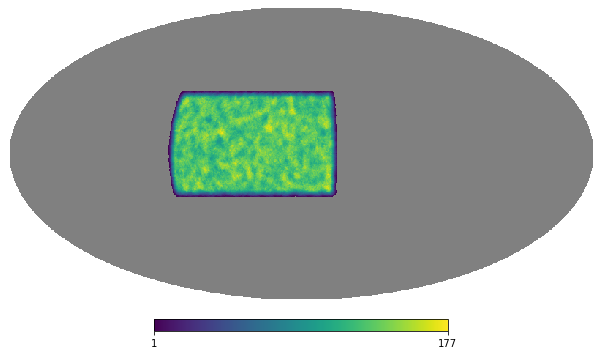

In [47]:
mysurvey.show()

## loads a dataset 

In [48]:
%%time
dset = skysurvey.DataSet.from_targets_and_survey(snia, mysurvey)

CPU times: user 2.79 s, sys: 485 ms, total: 3.27 s
Wall time: 3.34 s


In [53]:
dset.get_ndetection()

index
0      37
1      36
2      19
3       8
4      32
       ..
995    14
996     9
997     3
998    14
999    22
Name: detected, Length: 1000, dtype: int64

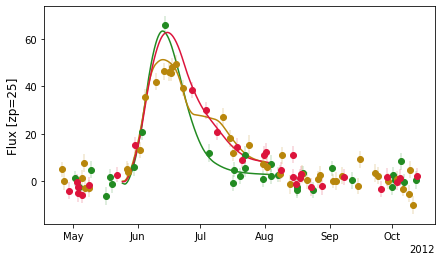

In [54]:
fig = dset.show_target_lightcurve(index=995, phase_window=[-50, 200])